In [3]:
from datascience import *
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

Data from the Social Security Administration is separated into many `.txt` files so we needed to combine them into a single `.csv` file.  We only took data from 1910 to 2010 in ten year intervals to match the age correction data that we had.

In [79]:
write_csv = open('../data/data1910-2010.csv', 'w')
SA_writer = csv.writer( write_csv, delimiter = ',', quotechar = '', quoting = csv.QUOTE_NONE)

#change these to change the range of years to pull data from
start    = 1910
end      = 2010
interval = 10

SA_writer.writerow(['year', 'first_name', 'gender', 'count'])
for year in range(start, end + interval, interval):
    f         = open('../data/yob'+str(year)+'.txt', 'r')
    read_csv  = csv.reader(f, delimiter = ',')

    for line in read_csv:
        if line[0].isspace() == False:
            SA_writer.writerow([year, str(line[0]), str(line[1]), int(line[2])])

    f.close()

Next we created a table out of the joined data and then split it into separate tables for men and women.  Then we found the total instances of each unique name and plotted the first twenty highest totals to compare with after making various adjustments.

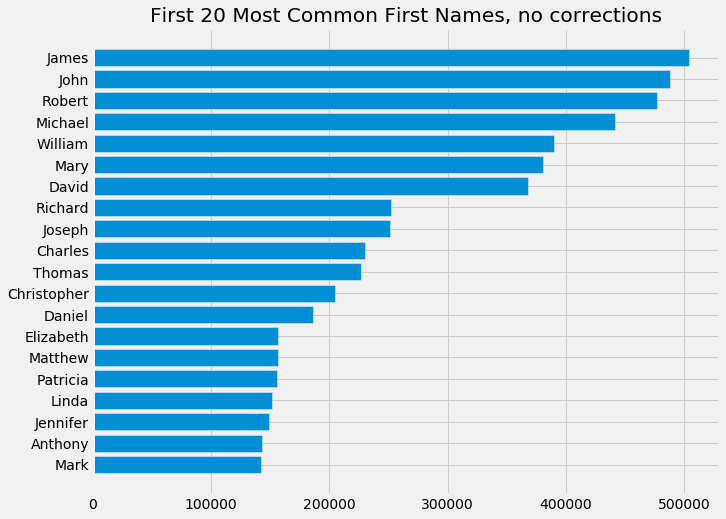

In [5]:
first_names = Table.read_table('../data/data1910-2010.csv')

male_first   = first_names.where('gender', 'M')
female_first = first_names.where('gender', 'F')

raw_total     = first_names.select(['first_name', 'count']).group('first_name', collect = sum)
raw_sorted    = raw_total.sort('count sum', descending = False)
first_20names = raw_sorted.take[raw_sorted.num_rows-20 : raw_sorted.num_rows]

plt.figure(1, figsize = (10,8))
plt.barh(first_20names.column('first_name'), first_20names.column('count sum'))
plt.title('First 20 Most Common First Names, no corrections')

plt.show()

Our raw data is tallying how many babies were given a particular name from year to year.  We're trying to look at the most popular name in 2013.  We need to account for people dying by reducing their contribution to the total.  To do this we tried to use the following table provided by the authors.

In [4]:
alive = Table.read_table('../data/aging-curve.csv')
alive.show(5)

Decade,Age,Male,Female,Male.1,Female.1
1900,113,0,0,0,0
1910,103,45,318,0.00045,0.00318
1920,93,4154,11403,0.04154,0.11403
1930,83,28836,44336,0.28836,0.44336
1940,73,58728,70955,0.58728,0.70955


Initially we thought that the Male/Female columns were telling us how many people born in a certain decade were still alive in 2013.  By using that column and finding the total number of baby names from each year, we turned the number of people alive into a percentage.

In [5]:
#split them into male and female tables
male_alive   = alive.select(['Decade', 'Age', 'Male'])
female_alive = alive.select(['Decade', 'Age', 'Female'])

# takes a table and returns total names in each year (use this as total people born that year)
def sum_by_year(table):
    total = []
    for year in range(1910, 2020, 10):
        year_total = 0
        year_total = table.where('year', year).column('count').sum()
        total.append(year_total)
    return total

male_total_by_year   = sum_by_year(male_first)
female_total_by_year = sum_by_year(female_first)

#exclude 1900 row
male_alive   = male_alive.exclude(0)
female_alive = female_alive.exclude(0)

#add year total column
male_alive   = male_alive.with_column('total', male_total_by_year)
female_alive = female_alive.with_column('total', female_total_by_year)

#take 'number still alive' column and divide by 'total by year' column
def find_percent(table, column):
    count   = table.column(column)
    total   = table.column('total')
    percent = count/total
    return table.with_column('percent_alive', percent)

male_percent   = find_percent(male_alive, 'Male')
female_percent = find_percent(female_alive, 'Female')

In [84]:
female_percent

Decade,Age,Female,total,percent_alive
1910,103,318,396502,0.000802014
1920,93,11403,1198290,0.00951606
1930,83,44336,1125885,0.0393788
1940,73,70955,1143393,0.0620565
1950,63,86389,1713151,0.050427
1960,53,92468,2022018,0.0457306
1970,43,95619,1748175,0.0546965
1980,33,97619,1660147,0.0588014
1990,23,98570,1898046,0.0519324
2000,13,99178,1815110,0.0546402


The percentages that we got didn't look right; only 5.2% of people born in 1990 were still alive.  We tried getting actuarial data from the SSA, but we could only find webpages with tables.  Since we didn't want to input the data by hand, we abandoned that idea.

So the next idea was to use the numbers in the Male.1 and Female.1 columns as the percent of people born that decade who are still alive.

In [6]:
#2nd attempt to correct for deaths

#people still alive in 2013
alive = Table.read_table('../data/aging-curve.csv')
alive = alive.exclude(0) #dropping 1900 row

#take the 'Male.1' and 'Female.1' columns (hopefully they mean percentage of people still alive from that year)
correction_m = alive.column('Male.1')
correction_f = alive.column('Female.1')

#function that applies the correction values to a table
def age_correct(table, value):
    corrected_counts = []
    index = 0
    for year in range(1910, 2020, 10):
        counts = table.where('year', year).column('count') #take rows from 'count' column where the year is the same
        counts = np.round(counts * value[index])           #the part where the correction is applied
        index  += 1                                        #index for the list of corrections, stops incrementing when you hit the year 2010
        corrected_counts.extend(list(counts))
    return corrected_counts

corrected_m  = age_correct(male_first, correction_m)
male_first   = male_first.with_column('age_corrected', corrected_m)
corrected_f  = age_correct(female_first, correction_f)
female_first = female_first.with_column('age_corrected', corrected_f)

In [87]:
female_first.show(5)

year,first_name,gender,count,age_corrected
1910,Mary,F,22848,73
1910,Helen,F,10479,33
1910,Margaret,F,8226,26
1910,Dorothy,F,7318,23
1910,Ruth,F,7212,23


So there were 22,848 Mary's born in 1910 and probably about 73 still around in 2013.  To check if this was reasonable, we summed the age_corrected column for men and women where the year was 1910 and added them together.

In [14]:
female_1910_sum = female_first.where('year', 1910).column('age_corrected').sum()
male_1910_sum   = male_first.where('year', 1910).column('age_corrected').sum()
female_1910_sum + male_1910_sum

1160.0

The 2010 US Census shows there were about 55k people 100 years old and older still alive; we're 'a bit' off unless the 'and older' crowd can make up the difference. ![alt text](../images/census_2010.jpg)

Moving on...we applied the age correction to the data.

In [7]:
male_total    = male_first.select(['first_name', 'age_corrected']).group('first_name', collect = sum)
female_total  = female_first.select(['first_name', 'age_corrected']).group('first_name', collect = sum)

joined_table = male_total.append(female_total)
sorted_first = joined_table.sort('age_corrected sum', descending = True)

#only used to plot top 20 first names
top20 = joined_table.sort('age_corrected sum', descending = False)
top20 = top20.take[joined_table.num_rows-20 : joined_table.num_rows]

In [8]:
sorted_first

first_name,age_corrected sum
Michael,391007
James,346796
John,325923
Robert,319500
David,306566
William,254855
Mary,227750
Christopher,193440
Joseph,184407
Richard,176680


In [8]:
#need this number later when we find the probability of each first name
total_names = joined_table.column('age_corrected sum').sum()

The 20 names with the highest totals after the age adjustment.  Michael jumped from 4th to 1st and some re-ordering at the bottom.

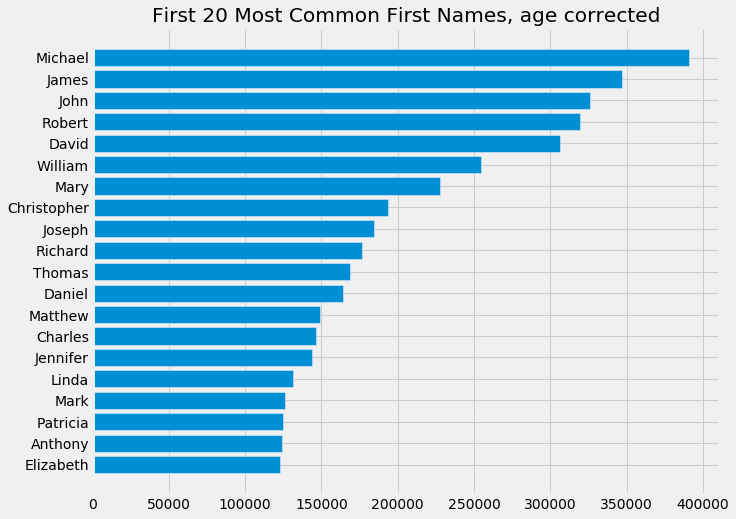

In [128]:
plt.figure(1, figsize = (10,8))
plt.barh(top20.column('first_name'), top20.column('age_corrected sum'))
plt.title('First 20 Most Common First Names, age corrected')

plt.show()

The authors also accounted for names not registered with the SSA, by weighting foreign names based on their ethnicity's percentage of the total population.  They only adjusted Hispanic names because they were the most numerous foreign born population.  We couldn't figure out how to do this with the data from the SSA, because the ethnicity of the name isn't flagged.  Doing this manually would require us to go through every name for every year and judge whether a particular name sounded Hispanic or not, so we skipped this step.

Now, looking at the last names data provided by the authors, they did provide information about the probable race of a person with a particular last name.

In [10]:
surnames = Table.read_table('../data/surnames.csv')
surnames.sort('pcthispanic', descending = True)

name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic
GOMEZGARCIA,63450,294,0.11,84303.2,0,(S),0,0,(S),99.66
HUERTERO,75938,236,0.09,85528.4,0,(S),0,0,(S),99.58
SUASTE,78326,227,0.08,85739.2,(S),(S),0,0,0,99.56
BUENRROSTRO,85643,203,0.08,86310.2,(S),(S),0,0,0,99.51
ANDABLO,85643,203,0.08,86307.2,(S),(S),0,0,0,99.51
TEPALE,86657,200,0.07,86405,(S),(S),0,0,0,99.5
TOXQUI,90252,190,0.07,86668.6,0,(S),(S),0,0,99.47
FERRUSCA,91801,186,0.07,86759,(S),(S),0,0,0,99.46
ARREZOLA,91801,186,0.07,86752.1,(S),(S),0,0,0,99.46
TLATENCHI,52289,373,0.14,82943,(S),(S),0,0,0,99.46


We had state by state total and hispanic population data, so our plan was to find the percentage of the U.S. population that was Hispanic and apply it to the count of a last name where `'pcthispanic' >= 80`, as an initial guess for a threshold.

In [13]:
state_pops = Table.read_table('../data/state-pop.csv')

total = list(state_pops.column('totalPop'))
hisp  = list(state_pops.column('hispPop'))

#the numbers in the table have commas, preventing type-casting and summing
#this function takes a column, removes commas, then sums the column
def sum_columns(lists):
    column_total = 0
    for i in range(len(lists)):
        column_total += int(lists[i].replace(',', ''))
    return column_total

#finding the percent Hispanic population in the U.S.
total_pop = sum_columns(total)
hisp_pop  = sum_columns(hisp)

per_hisp = hisp_pop / total_pop
per_hisp

0.1634925457610986

To work with the surnames table, NAN need to be removed and the 'numbers' need to be converted to actual numbers.  This next section takes a long time and eats memory; the output will be saved to `(../data/surnames_no_nan.csv)` and then loaded in a later cell.

In [87]:
#Modified Chris Pyles' code to remove NAN from daredevil lab; original copyright Christopher Pyles <cpyles@berkeley.edu>
def remove_nan(t):
    
    def checkNotnan(val):
        if (val!=val) or (val=='nan') or (val=='NAN') or (val=='NaN') or (val=='(S)'):
            return False
        return True
    
    labels = t.labels
    for label in labels:
        t = t.where(label, checkNotnan)
    return t

surnames = surnames.drop(['pctwhite', 'pctblack', 'pctapi', 'pctaian', 'pct2prace']) #drop these so we don't lose rows with high pcthispanic just because that row contains a NAN
surnames = remove_nan(surnames)
surnames.to_csv('../output/surnames_no_nan.csv')#save to file so we can continue from here later

In [14]:
#loading the NAN removed table
lastnames = Table.read_table('../output/surnames_no_nan.csv')

#functions that convert table entries to numbers
def to_int(entry):
    if type(entry) == int:
        return entry
    return int(entry)

def to_float(entry):
    if type(entry) == float:
        return entry
    return float(entry)

count     = lastnames.apply(to_int, 'count')
lastnames = lastnames.drop('count')
lastnames = lastnames.with_columns('count', count)
pcthisp   = lastnames.apply(to_float, 'pcthispanic')
lastnames = lastnames.drop('pcthispanic')
lastnames = lastnames.with_columns('pcthispanic', pcthisp)

This part increases the count of lastnames by 16% if `'pcthispanic'` is 80 or greater.

In [15]:
threshold = 80 #value in 'pcthispanic' column has to be >= this for their count to be adjusted

def adj_hisp(entry):
    return entry * (1 + per_hisp)

In [16]:
#pull out separate columns from table and join them as a matrix
pcthisp = list(lastnames.column('pcthispanic'))
count   = list(lastnames.column('count'))
stack   = np.stack((pcthisp, count), axis = -1)

In [17]:
#perform the adjustment
for row in stack:
    if row[0] >= threshold:
        row[1] = adj_hisp(row[1])

#make a list with the adjusted values
adjusted_count = []
for i in range(len(stack)):
    adjusted_count.append(int(stack[i,1]))

lastname = lastnames.with_column('adjusted_count', adjusted_count)
lastname

name,rank,prop100k,cum_prop100k,count,pcthispanic,adjusted_count
SMITH,1,880.85,880.85,2376206,1.56,2376206
JOHNSON,2,688.44,1569.3,1857160,1.5,1857160
WILLIAMS,3,568.66,2137.96,1534042,1.6,1534042
BROWN,4,511.62,2649.58,1380145,1.64,1380145
JONES,5,505.17,3154.75,1362755,1.44,1362755
MILLER,6,418.07,3572.82,1127803,1.43,1127803
DAVIS,7,397.51,3970.33,1072335,1.58,1072335
GARCIA,8,318.17,4288.5,858289,90.81,998612
RODRIGUEZ,9,298.13,4586.62,804240,92.7,935727
WILSON,10,290.27,4876.9,783051,1.73,783051


Next the authors found the probability of having a certain first or last name by dividing each count by the total population.  We also kept only the first 100 names from each table after sorting by probability.

In [18]:
def first_to_percent(entry):
    return entry / total_names

def last_to_percent(entry):
    return entry / total_pop

first_prob = sorted_first.apply(first_to_percent, 'age_corrected sum')
firstname  = sorted_first.with_column('probability', first_prob)

last_prob = lastname.apply(last_to_percent, 'adjusted_count')
lastname  = lastname.with_column('probability', last_prob)

In [19]:
firstname

first_name,age_corrected sum,probability
Michael,391007,0.0144143
James,346796,0.0127845
John,325923,0.012015
Robert,319500,0.0117782
David,306566,0.0113014
William,254855,0.00939512
Mary,227750,0.00839591
Christopher,193440,0.00713109
Joseph,184407,0.00679809
Richard,176680,0.00651324


In [24]:
first_100 = firstname.take[:100]

first_100.to_csv('../output/first_100.csv')

In [25]:
sort_last = lastname.sort('probability', descending = True)
last_100  = sort_last.take[:100]

last_100.to_csv('../output/last_100.csv')

Now we make two tables with just names and probabilites, convert them to arrays and combine them into another array whose elements will be the probablity of first name times the probability of last name.  Then we made a table out of the probability array.

In [20]:
#un-comment below to load output of previous cells and continue from here
# first_100 = Table.read_table('../output/first_100.csv')
# last_100  = Table.read_table('../output/last_100.csv')

lastnames   = list(last_100.column('name'))
last_prob   = list(last_100.column('probability'))
first_names = list(first_100.column('first_name'))
first_prob  = list(first_100.column('probability'))

#this part converts last name strings to lowercase and then capitalizes the first letter
last_names = []
for element in lastnames:
    lower  = element.lower()
    proper = lower.capitalize()
    last_names.append(proper)

name_array = np.zeros([100, 100])
for first in range(len(first_prob)):
    for last in range(len(last_prob)):
        name_array[first, last] = first_prob[first] * last_prob[last]

In [21]:
#original copyright Christopher Pyles <cpyles@berkeley.edu>
import pandas as pd
df = pd.DataFrame(name_array)
string_labels = list(map(str, df.columns))
df = df.rename({i:j for i, j in zip(df.columns, string_labels)}, axis=1)
name_table = Table.from_df(df)

In [22]:
column_labels = name_table.labels
name_table    = name_table.relabel(column_labels, last_names)
name_table    = name_table.with_column('First Names', first_names)
name_table    = name_table.move_to_start('First Names')

In [23]:
name_table

First Names,Smith,Johnson,Williams,Brown,Jones,Miller,Davis,Garcia,Rodriguez,Martinez,Hernandez,Wilson,Anderson,Lopez,Taylor,Thomas,Moore,Gonzalez,Martin,Jackson,Thompson,White,Lee,Harris,Perez,Clark,Sanchez,Lewis,Robinson,Walker,Hall,Young,Allen,Ramirez,Wright,King,Scott,Green,Baker,Adams,Nelson,Hill,Torres,Campbell,Mitchell,Roberts,Flores,Carter,Phillips,Rivera,Evans,Turner,Parker,Collins,Edwards,Stewart,Morris,Nguyen,Gomez,Murphy,Cook,Rogers,Diaz,Morgan,Peterson,Reyes,Cooper,Cruz,Reed,Bailey,Bell,Kelly,Howard,Ward,Cox,Morales,Ortiz,Richardson,Gutierrez,Wood,Watson,Brooks,Bennett,Gray,James,Hughes,Price,Gonzales,Myers,Ramos,Long,Foster,Sanders,Ross,Powell,Chavez,Sullivan,Russell,Jenkins,Perry
Michael,0.000110937,8.67047e-05,7.16194e-05,6.44344e-05,6.36225e-05,5.26534e-05,5.00638e-05,4.66219e-05,4.3686e-05,4.21016e-05,3.83698e-05,3.65581e-05,3.55937e-05,3.37616e-05,3.36317e-05,3.31801e-05,3.26186e-05,3.24678e-05,3.14067e-05,3.10992e-05,3.00834e-05,2.98568e-05,2.82856e-05,2.77105e-05,2.65363e-05,2.56015e-05,2.39681e-05,2.3807e-05,2.34847e-05,2.34044e-05,2.21093e-05,2.17536e-05,2.16331e-05,2.11296e-05,2.05593e-05,2.04948e-05,1.96127e-05,1.93039e-05,1.9298e-05,1.92856e-05,1.92459e-05,1.92242e-05,1.7663e-05,1.73653e-05,1.71542e-05,1.70974e-05,1.69811e-05,1.69262e-05,1.64266e-05,1.62667e-05,1.59779e-05,1.5671e-05,1.5138e-05,1.48393e-05,1.4803e-05,1.46082e-05,1.45548e-05,1.44787e-05,1.43181e-05,1.40294e-05,1.3763e-05,1.37447e-05,1.36761e-05,1.29042e-05,1.28408e-05,1.26299e-05,1.26099e-05,1.25513e-05,1.2486e-05,1.24147e-05,1.23604e-05,1.21565e-05,1.18948e-05,1.18641e-05,1.18477e-05,1.18222e-05,1.16615e-05,1.16499e-05,1.15649e-05,1.15456e-05,1.13184e-05,1.12399e-05,1.11607e-05,1.10513e-05,1.08885e-05,1.07095e-05,1.06799e-05,1.05344e-05,1.04963e-05,1.04889e-05,1.04342e-05,1.03196e-05,1.03132e-05,1.02693e-05,1.01101e-05,1.00961e-05,1.00675e-05,1.00578e-05,9.97868e-06,9.92765e-06
James,9.83936e-05,7.6901e-05,6.35214e-05,5.71488e-05,5.64288e-05,4.66999e-05,4.44031e-05,4.13504e-05,3.87464e-05,3.73412e-05,3.40314e-05,3.24245e-05,3.15691e-05,2.99442e-05,2.9829e-05,2.94284e-05,2.89305e-05,2.87967e-05,2.78555e-05,2.75828e-05,2.66819e-05,2.64809e-05,2.50874e-05,2.45773e-05,2.35358e-05,2.27068e-05,2.1258e-05,2.11151e-05,2.08293e-05,2.0758e-05,1.96094e-05,1.92939e-05,1.91871e-05,1.87405e-05,1.82347e-05,1.81775e-05,1.73951e-05,1.71212e-05,1.7116e-05,1.7105e-05,1.70698e-05,1.70505e-05,1.56659e-05,1.54018e-05,1.52146e-05,1.51642e-05,1.50611e-05,1.50123e-05,1.45693e-05,1.44274e-05,1.41713e-05,1.38991e-05,1.34263e-05,1.31614e-05,1.31292e-05,1.29565e-05,1.29091e-05,1.28416e-05,1.26992e-05,1.24431e-05,1.22068e-05,1.21906e-05,1.21298e-05,1.14451e-05,1.13889e-05,1.12018e-05,1.11841e-05,1.11322e-05,1.10742e-05,1.1011e-05,1.09628e-05,1.0782e-05,1.05499e-05,1.05226e-05,1.05081e-05,1.04855e-05,1.03429e-05,1.03326e-05,1.02573e-05,1.02401e-05,1.00386e-05,9.96898e-06,9.89876e-06,9.80178e-06,9.65731e-06,9.49855e-06,9.4723e-06,9.34327e-06,9.30948e-06,9.3029e-06,9.25441e-06,9.15279e-06,9.14708e-06,9.10811e-06,8.967e-06,8.95453e-06,8.92919e-06,8.92058e-06,8.85039e-06,8.80513e-06
John,9.24715e-05,7.22725e-05,5.96982e-05,5.37092e-05,5.30324e-05,4.38891e-05,4.17306e-05,3.88616e-05,3.64144e-05,3.50937e-05,3.19831e-05,3.04729e-05,2.9669e-05,2.81419e-05,2.80336e-05,2.76572e-05,2.71892e-05,2.70635e-05,2.61789e-05,2.59227e-05,2.5076e-05,2.48871e-05,2.35774e-05,2.3098e-05,2.21192e-05,2.13401e-05,1.99785e-05,1.98442e-05,1.95756e-05,1.95087e-05,1.84292e-05,1.81326e-05,1.80322e-05,1.76125e-05,1.71371e-05,1.70834e-05,1.63481e-05,1.60907e-05,1.60858e-05,1.60755e-05,1.60424e-05,1.60243e-05,1.4723e-05,1.44748e-05,1.42989e-05,1.42515e-05,1.41546e-05,1.41088e-05,1.36924e-05,1.3559e-05,1.33184e-05,1.30625e-05,1.26182e-05,1.23692e-05,1.2339e-05,1.21767e-05,1.21321e-05,1.20687e-05,1.19348e-05,1.16942e-05,1.14721e-05,1.14569e-05,1.13997e-05,1.07563e-05,1.07034e-05,1.05276e-05,1.0511e-05,1.04621e-05,1.04077e-05,1.03483e-05,1.0303e-05,1.0133e-05,9.91488e-06,9.88927e-06,9.87565e-06,9.85436

This table says you have a `9.7e-04` chance of being named Michael Smith, `7.6e-04` chance of being named Michael Johnson, etc.  It assumes first and last names are independent variables and the probability of having a certain first and last name combination is just the product of probabilities.

But names are not random combinations of possible names.  The authors tried to correct for this by using a matrix from a study by another researcher ([Lee Hartman](http://mypage.siu.edu/lhartman/johnsmith.html)).  This is their correction matrix.

In [24]:
adjustments = Table.read_table('../data/adjustments.csv')
adjustments

Unnamed: 0,Miller,Anderson,Martin,Smith,Thompson,Wilson,Moore,White,Taylor,Davis,Johnson,Brown,Jones,Thomas,Williams,Jackson,Lee,Garcia,Martinez,Rodriguez
John,8.4,6.9,13.4,-23.5,3.6,2.5,3.6,1.7,0.4,-3.8,-35.2,-34.3,-26.5,5.1,-11.3,-27.7,-8.3,-66.4,-63.6,-69.5
Michael,18.1,2.4,13,5.6,6.7,2.6,15.7,-1.7,0.6,2.5,-4.8,4.2,-2.4,2.9,-8.1,-16.8,-9.8,-54.7,-54.4,-63.2
James,20.3,24,35.9,21.1,33.6,40.9,43,41,37.4,32.8,9.6,25.4,8.9,24.8,20.7,19.8,12.2,-84.4,-83.9,-87.4
Robert,29.6,27,16.8,8.7,18,22,17.2,18.1,39.2,7.2,5.9,14.2,12.6,4.8,-1.3,-1.8,12.1,-57.4,-55.1,-61
David,27.9,28.1,15.8,10.8,11,12.6,8.8,16.2,-1.5,-44.7,3.5,10.3,5,0.9,-7.3,-15.4,10.1,-30.5,-28.5,-31.7
Mary,21.5,18.2,26.2,14.7,18.5,18.9,22.8,22.5,16,14.8,11.7,13.1,12.2,18.9,13.1,8.7,-16.4,-42.4,-41.3,-54
William,22.5,7,33.3,16.6,29.3,21.5,31.9,38.2,29.2,23.1,4.3,22.3,15.4,19.8,-59.1,9.6,-11.4,-82.3,-80.2,-74.2
Richard,24.1,22.9,12.6,6.2,8.4,1.7,7.3,12.2,5,5.2,-2,3.9,-4.6,-2.3,-17,-21.6,-6.6,-43.2,-43,-47.7
Thomas,12.9,3,22.1,-2.6,-3.5,9.7,32.2,13.2,4.3,-5.9,-15,1.8,-3.5,-81.1,-11.5,-11,-8.9,-77.8,-75.6,-84.2
Jennifer,24.9,17.3,22.5,16.7,15.2,14.8,11.5,14.8,14.9,8.7,10.3,6.5,24,-1.6,-7.4,-6.3,22.5,-32.9,-32.2,-33.2


The ethnicity adjustment table only has certain `first` + `last` `name` combinations; in order to use it we need to have our table match the names.

In [25]:
#selecting the last names in the correction matrix; happily the order of last names match
last_names_to_keep = ['Miller' , 'Anderson', 'Martin', 'Smith'   , 'Thompson',
                      'Wilson' , 'Moore'   , 'White' , 'Taylor'  , 'Davis'   ,
                      'Johnson', 'Brown'   , 'Jones' , 'Thomas'  , 'Williams',
                      'Jackson', 'Lee'     , 'Garcia', 'Martinez', 'Rodriguez']

reduced = name_table.select(last_names_to_keep)
reduced = reduced.with_column('First Names', first_names)
reduced = reduced.move_to_start('First Names')

In [26]:
#selecting the first names in the correction matrix
def drop_first_names(entry):
    to_keep = ['John'    , 'Michael', 'James'  , 'Robert', 'David'   ,
               'Mary'    , 'William', 'Richard', 'Thomas', 'Jennifer',
               'Patricia', 'Joseph' , 'Linda'  , 'Maria' , 'Charles' ,
               'Barbara' , 'Mark'   , 'Daniel' , 'Susan' , 'Elizabeth']

    for name in to_keep:
        if entry == name:
            return True
    return False

#the order of first names in the correction matrix
first_names_order = [2, 0, 1, 3, 4, 6, 5, 8, 9, 12, 15, 7, 13, 19, 11, 17, 14, 10, 18, 16]

matching_size = reduced.where('First Names', drop_first_names)
matching      = matching_size.take(first_names_order) #matching the order of rows in the correction matrix

In [39]:
#building the final adjusted table of first and last names
result = Table.empty()
first_names_to_keep = ['John'    , 'Michael', 'James'  , 'Robert', 'David'   ,
                       'Mary'    , 'William', 'Richard', 'Thomas', 'Jennifer',
                       'Patricia', 'Joseph' , 'Linda'  , 'Maria' , 'Charles' ,
                       'Barbara' , 'Mark'   , 'Daniel' , 'Susan' , 'Elizabeth']
i = 1
for label in last_names_to_keep:
    a = matching.column(i)
    b = 1 + adjustments.column(i)/100
    c = np.round(a*b*1e6, 1) #multiplied by 1e6 to match order of magnitude of author's final table
    result = result.with_columns(label, c)
    i += 1

result = result.with_column('First Names', first_names_to_keep)
result = result.move_to_start('First Names')

Finally, we tried to reorder the table, yet again, to match the author's final table, but some of the names in their table are not in the `adjustment` matrix.  We were not sure why they dropped the names they did, where these new names with no values came from, nor why they added them in the first place.

In [40]:
result.to_csv('../output/result.csv')
result.show()

First Names,Miller,Anderson,Martin,Smith,Thompson,Wilson,Moore,White,Taylor,Davis,Johnson,Brown,Jones,Thomas,Williams,Jackson,Lee,Garcia,Martinez,Rodriguez
John,47.6,31.7,29.7,70.7,26,31.2,28.2,25.3,28.1,40.1,46.8,35.3,39,29.1,53,18.7,21.6,13.1,12.8,11.1
Michael,62.2,36.4,35.5,117.1,32.1,37.5,37.7,29.3,33.8,51.3,82.5,67.1,62.1,34.1,65.8,25.9,25.5,21.1,19.2,16.1
James,56.2,39.1,37.9,119.2,35.6,45.7,41.4,37.3,41,59,84.3,71.7,61.5,36.7,76.7,33,28.1,6.5,6,4.9
Robert,55.8,36.9,30,98.5,29,36.4,31.2,28.8,38.3,43.9,75,60.1,58.5,28.4,57.8,25,25.9,16.2,15.4,13.9
David,52.8,35.7,28.5,96.4,26.2,32.3,27.8,27.2,26,21.7,70.4,55.7,52.4,26.2,52.1,20.6,24.4,25.4,23.6,23.4
Mary,37.3,24.5,23.1,74.1,20.8,25.3,23.3,21.3,22.7,33.5,56.4,42.4,41.6,23,47.2,19.7,13.8,15.6,14.4,11.7
William,42,24.8,27.3,84.3,25.4,29,28,26.9,28.3,40.2,58.9,51.4,47.9,25.9,19.1,22.2,16.3,5.4,5.4,7.3
Richard,29.5,19.8,16,53.2,14.7,16.8,15.8,15.1,16,23.8,38.4,30.3,27.4,14.6,26.9,11,11.9,12,10.8,10.3
Thomas,25.6,15.8,16.5,46.6,12.5,17.3,18.6,14.6,15.1,20.3,31.8,28.3,26.5,2.7,27.3,11.9,11.1,4.5,4.4,3
Jennifer,24.2,15.4,14.2,47.7,12.8,15.5,13.4,12.6,14.2,20.1,35.3,25.3,29.1,12,24.4,10.7,12.8,11.5,10.5,10.8


This is our final adjusted table.  For comparison, the author's table is:

<center><img src="../images/original_result.png" width="1000px"/></center>